In [49]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path
import flammkuchen as fl
from cycler import cycler

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
import seaborn as sns


In [51]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [52]:
from megabouts.tracking_data import TrackingConfig, FullTrackingData, load_example_data
from megabouts.pipeline import FullTrackingPipeline
from megabouts.utils import (
    bouts_category_name,
    bouts_category_name_short,
    bouts_category_color,
    cmp_bouts,
)

In [53]:
from megabouts.tracking_data import TrackingConfig, FullTrackingData, load_example_data
from megabouts.config import TailPreprocessingConfig
from megabouts.preprocessing import TailPreprocessing
import random

In [54]:
from mb_helper import labels_cat, color
from mb_helper import compute_body_angle

# Load Bouts

In [55]:
master_path = Path(Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata') / 'Raw_Data')
out_path = Path(master_path/'Processed_Data')
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0')]

In [56]:
fish= 0
fish_path = fish_paths[fish]
fish_id =  fish_paths[fish].name
exp_name = 'testfish'
exp_name, fish_id

('testfish', '240423_f0')

### Load DLC

In [57]:
fps=200
mm_per_unit = 1/70
N_seg = 10

In [58]:
df = pd.read_csv(out_path/ '{}_DLC_mod.csv'.format(fish_id), header=[0, 1])


In [59]:
df.head()

Unnamed: 0_level_0 bodyparts DLC_filter     motor                      \
  Unnamed: 0_level_1    coords        pos         z         y         x   
0                  0         0          1  0.000000  8.993996 -7.050400   
1                  1         1          1 -0.000137  9.084572 -7.089576   
2                  2         2          1  0.000000  9.179195 -7.108448   
3                  3         3          1  0.000000  9.258852 -7.098520   
4                  4         4          1 -0.000013  9.320093 -7.081586   

  edge_filter left_eye_anterior                         ...     tail_8  \
           ok                 x           y likelihood  ... likelihood   
0        True        645.326900  521.443017   0.999891  ...   0.998467   
1        True        646.183150  519.644351   0.999896  ...   0.998625   
2        True        650.207855  517.061760   0.999923  ...   0.999190   
3        True        654.625610  513.145553   0.999913  ...   0.997801   
4        True        657.924704  510.390997   0.999740  ...   0.998626   

       tail_9                            tail_10                         \
            x           y likelihood           x           y likelihood   
0  463.398844  250.457989   0.998467  439.471039  239.365433   0.998467   
1  473.571332  246.601053   0.998625  444.348114  245.641525   0.998625   
2  491.481593  238.960160   0.999190  461.540009  236.261642   0.999190   
3  503.204287  227.416002   0.997801  476.081390  216.947006   0.997801   
4  506.768862  217.844257   0.998626  485.563690  199.774689   0.998626   

     mid_head                         
            x           y likelihood  
0  633.807176  544.905587   0.998467  
1  634.773111  542.948934   0.998625  
2  638.426775  540.509511   0.999190  
3  643.096984  536.308950   0.997801  
4  646.209680  533.732044   0.998626  

[5 rows x 71 columns]

In [60]:
print(f'{df.shape[0]/(fps*60)} minutes at {fps} fps')
print('working on {} frames'.format(df.shape[0]))

#Extract angles
body_x = df.body.values[:, 0].astype('float')
body_y = df.body.values[:, 1].astype('float')

tail_x_col = [f'tail_{i}' for i in range(N_seg)]
tail_y_col = [f'tail_{i}' for i in range(N_seg)]
tail_x = np.array([df[x].iloc[:, 0].values.astype('float') for x in tail_x_col])
tail_y = np.array([df[x].iloc[:, 1].values.astype('float') for x in tail_y_col])


7.9519166666666665 minutes at 200 fps
working on 95423 frames


In [61]:
head_x = df.mid_head.values[:, 0].astype('float') * mm_per_unit
head_y = df.mid_head.values[:, 1].astype('float') * mm_per_unit

### Create tracking data

In [62]:
# Load data and set tracking configuration
tracking_cfg = TrackingConfig(fps=fps, tracking="full_tracking")

# Compute head and tail coordinates and convert to mm
tail_x_col = [f'tail_{i}' for i in range(N_seg)]
tail_y_col = [f'tail_{i}' for i in range(N_seg)]
tail_x = np.array([df[x].iloc[:, 0].values.astype('float') for x in tail_x_col]) * mm_per_unit
tail_y = np.array([df[x].iloc[:, 1].values.astype('float') for x in tail_y_col]) * mm_per_unit
head_x = df.mid_head.values[:, 0].astype('float') * mm_per_unit
head_y = df.mid_head.values[:, 1].astype('float') * mm_per_unit


In [63]:
## compute body angle over whole experiment
body_x_ = np.asarray(df.body.values[:, 0].astype('float'))
body_y_ = np.asarray(df.body.values[:, 1].astype('float'))

head_x_ = np.asarray(df.mid_head.values[:, 0].astype('float'))
head_y_ = np.asarray(df.mid_head.values[:, 1].astype('float'))


angles_radians, angles_degrees = compute_body_angle(head_x_, head_y_, body_x_, body_y_)

print(f"Angles in radians: {angles_radians}")
print(f"Angles in degrees: {angles_degrees}")

Angles in radians: [-2.00363609 -2.00187956 -1.99634328 ... -2.95366955 -2.94051827
 -2.93854352]
Angles in degrees: [-114.79989141 -114.69924993 -114.38204466 ... -169.23279937 -168.47928621
 -168.36614146]


In [64]:
# Create FullTrackingData object
tracking_data = FullTrackingData.from_keypoints(
    head_x=head_x, head_y=head_y, tail_x=tail_x.T, tail_y=tail_y.T
)

## Run new Megabouts Pipeline

In [65]:
pipeline = FullTrackingPipeline(tracking_cfg, exclude_CS=True)

In [66]:
pipeline.segmentation_cfg.threshold = 20

In [67]:
pipeline.tail_preprocessing_cfg.tail_speed_filter_ms = 50

In [68]:
pipeline.tail_preprocessing_cfg

TailPreprocessingConfig(fps=200, limit_na_ms=100, num_pcs=4, savgol_window_ms=15, baseline_method='median', baseline_params={'fps': 200, 'half_window': 100}, tail_speed_filter_ms=50, tail_speed_boxcar_filter_ms=14)

In [69]:
ethogram, bouts, segments, tail, traj = pipeline.run(tracking_data)

C:\Users\admin\miniconda3\envs\base_env\Lib\site-packages\megabouts\classification\classification.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(transforme

## Visualise results

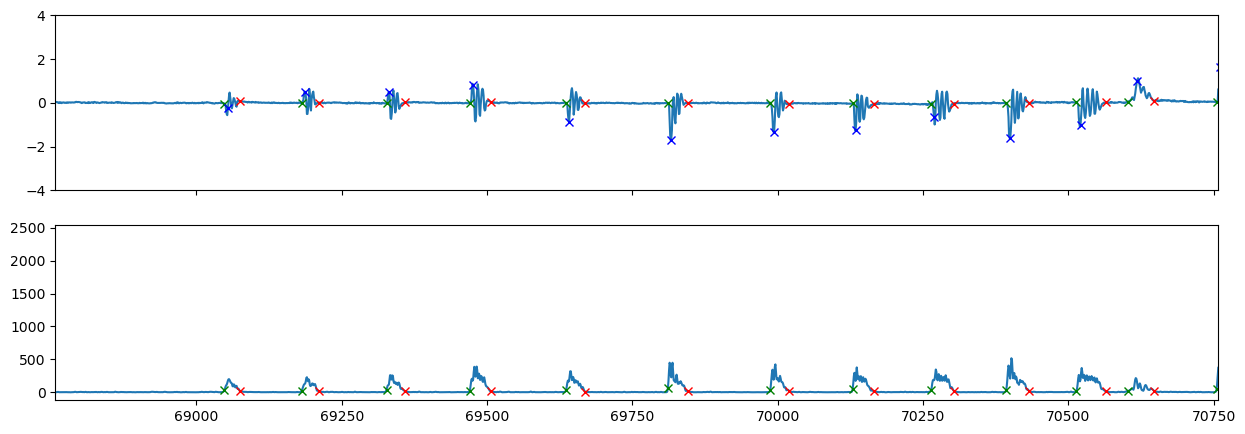

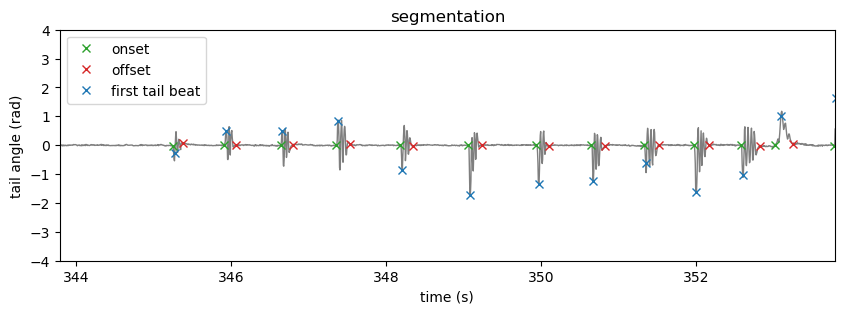

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

x = tracking_data._tail_angle[:, 7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x", color="green")
ax[0].plot(segments.offset, x[segments.offset], "x", color="red")
ax[0].plot(segments.HB1, x[segments.HB1], "x", color="blue")
ax[0].set_ylim(-4, 4)

x = tail.vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x", color="green")
ax[1].plot(segments.offset, x[segments.offset], "x", color="red")

t = np.arange(tracking_data.T) / tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10 * tracking_cfg.fps
ax[1].set_xlim(IdSt, IdSt + Duration)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
x = tail.df.angle_smooth.iloc[:, 7]
ax.plot(t, x, color="tab:grey", lw=1)
ax.plot(t[segments.onset], x[segments.onset], "x", color="tab:green", label="onset")
ax.plot(t[segments.offset], x[segments.offset], "x", color="tab:red", label="offset")
ax.plot(
    t[segments.HB1], x[segments.HB1], "x", color="tab:blue", label="first tail beat"
)
ax.set(
    **{
        "title": "segmentation",
        "xlim": (t[IdSt], t[IdSt + Duration]),
        "ylim": (-4, 4),
        "ylabel": "tail angle (rad)",
        "xlabel": "time (s)",
    }
)
ax.legend()
plt.show()

(342,)


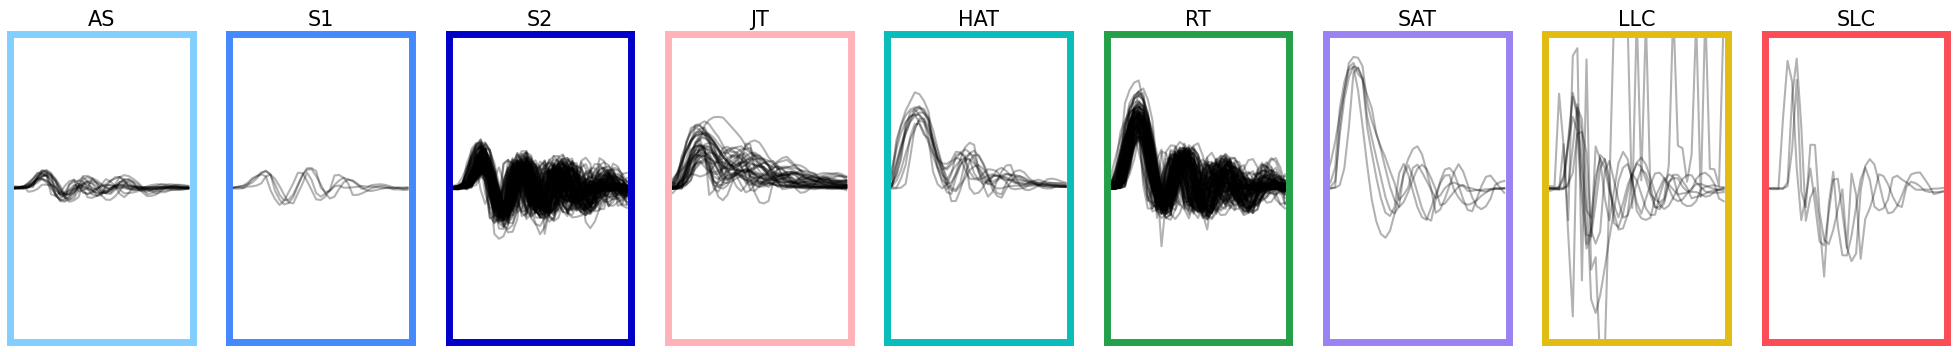

In [71]:
thr_proba = 0.9

id_b = np.unique(bouts.df.label.category[bouts.df.label.proba > thr_proba]).astype("int")
print(bouts.df.label.category[bouts.df.label.proba > thr_proba].shape)
fig, ax = plt.subplots(facecolor="white", figsize=(25, 4))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(1, len(id_b))
ax0 = {}
for i, b in enumerate(id_b):
    ax0 = plt.subplot(G[i])
    ax0.set_title(bouts_category_name_short[b], fontsize=15)
    for i_sg, sg in enumerate([1, -1]):
        id = bouts.df[
            (bouts.df.label.category == b)
            & (bouts.df.label.sign == sg)
            & (bouts.df.label.proba > thr_proba)
        ].index
        if len(id) > 0:
            ax0.plot(sg * bouts.tail[id, 7, :].T, color="k", alpha=0.3)
        ax0.set_xlim(0, pipeline.segmentation_cfg.bout_duration)
        ax0.set_ylim(-4, 4)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ["top", "bottom", "left", "right"]:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)

plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_6544\3850899793.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  ethogram.df[("bout", "cat")].values[IdSt:IdEd].T,
C:\Users\admin\AppData\Local\Temp\ipykernel_6544\3850899793.py:44: PerformanceWarning: indexing past lexsort depth may impact performance.
  id_b = np.unique(ethogram.df[("bout", "id")].values[IdSt:IdEd]).astype("int")


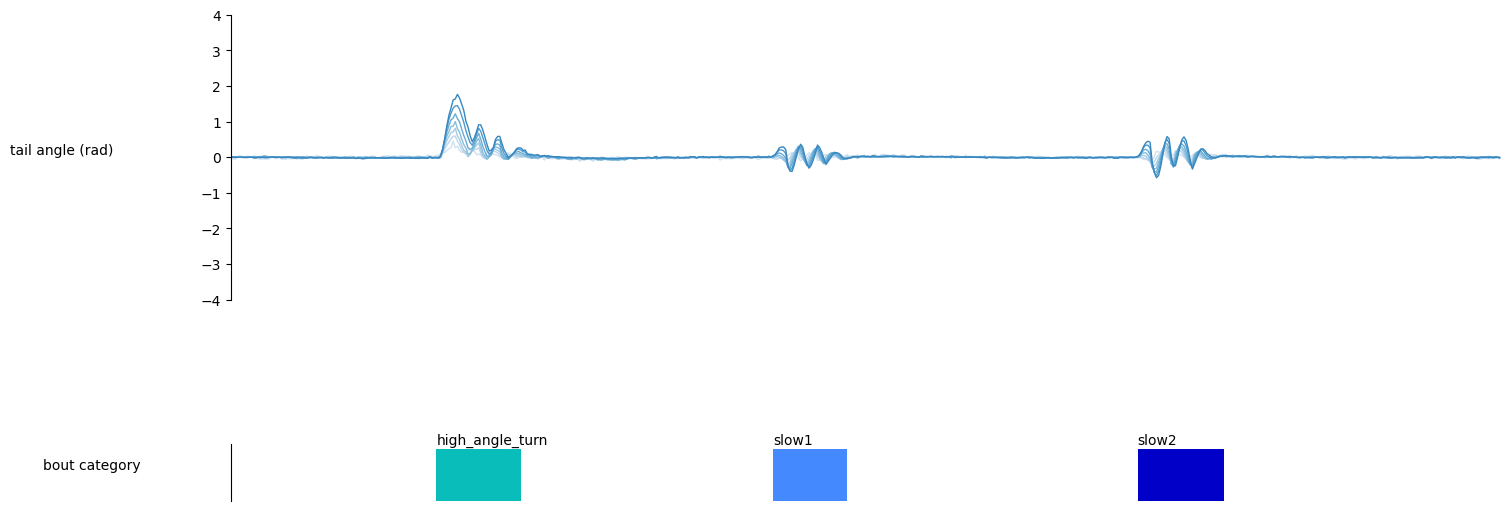

In [72]:
IdSt = np.random.randint(tracking_data.T)
T = 3
Duration = T * tracking_cfg.fps
IdEd = IdSt + Duration
t = np.arange(Duration) / tracking_cfg.fps


fig = plt.figure(facecolor="white", figsize=(15, 5), constrained_layout=True)
G = gridspec.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0.5, figure=fig)
ax = plt.subplot(G[0, 0])
blue_cycler = cycler(color=plt.cm.Blues(np.linspace(0.2, 0.9, 10)))
ax.set_prop_cycle(blue_cycler)

ax.plot(t, ethogram.df["tail_angle"].values[IdSt:IdEd, :7], lw=1)
ax.set_ylim(-4, 4)
ax.set_xlim(0, T)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.set_ylabel("tail angle (rad)", rotation=0, labelpad=100)

ax = plt.subplot(G[1, 0])
ax.imshow(
    ethogram.df[("bout", "cat")].values[IdSt:IdEd].T,
    cmap=cmp_bouts,
    aspect="auto",
    vmin=0,
    vmax=12,
    interpolation="nearest",
    extent=(0, T, 0, 1),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim(0, T)
ax.set_ylim(0, 1.1)

id_b = np.unique(ethogram.df[("bout", "id")].values[IdSt:IdEd]).astype("int")
id_b = id_b[id_b > -1]
for i in id_b:
    on_ = bouts.df.iloc[i][("location", "onset")]
    b = bouts.df.iloc[i][("label", "category")]
    ax.text((on_ - IdSt) / tracking_cfg.fps, 1.1, bouts_category_name[int(b)])

ax.set_ylabel("bout category", rotation=0, labelpad=100)
plt.show()

#### Create new megabouts_res.h5

In [74]:

megabouts_res = dict({
    'segments_on': np.asarray(segments.onset),
    'segments_off': np.asarray(segments.offset),
    'cluster_n_vector': np.asarray(ethogram.df[("bout", "cat")].values),
    'clusters':  np.asarray(bouts.df.label.category),
    'laterality' :np.asarray(bouts.df.label.sign),
    'proba' :np.asarray(bouts.df.label.proba),
    
    'clean_data_tail':np.asarray(ethogram.df["tail_angle"].values),
    'body_angle_rad' :np.asarray(angles_radians),
    'body_angle_deg' :np.asarray(angles_degrees),
    'head_angle_mb' :np.asarray(traj.yaw_smooth),
    'duration' : np.asarray(bouts.df.location.offset - bouts.df.location.onset),
    'bouts_df': bouts.df, 
    'ethogram_df': ethogram.df,
})
fl.save(out_path/'{}_megabouts_res.h5'.format(fish_id), megabouts_res)

C:\Users\admin\AppData\Local\Temp\ipykernel_6544\3261835291.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  'cluster_n_vector': np.asarray(ethogram.df[("bout", "cat")].values),
